# Introduction to Bayesian Computing

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from scipy import stats

# Visual style
az.style.use('arviz-doc')
pio.templates.default = 'plotly_white'

# Plotly defaults
px.defaults.template = 'plotly_white'
px.defaults.width = 900
px.defaults.height = 500
_base = pio.templates['plotly_white']
_tmpl = go.layout.Template(_base)
_tmpl.layout.hovermode = 'x unified'
pio.templates['hoverx'] = _tmpl
pio.templates.default = 'plotly_white+hoverx'

# Reproducibility
RANDOM_SEED = 20090425
RNG = np.random.default_rng(RANDOM_SEED)

The process of conducting Bayesian inference can be broken down into three general steps (Gelman *et al.* 2013):

![](images/123.png)

### Step 1: Specify a probability model

Bayesian statistics involves using probability models to solve problems. So, the first task is to *completely specify* the model in terms of probability distributions. This includes everything: unknown parameters, data, covariates, missing data, predictions. All must be assigned some probability density.

This step involves making choices.

- what is the form of the sampling distribution of the data?
- what form best describes our uncertainty in the unknown parameters?

### Step 2: Calculate a posterior distribution

The mathematical form $p(\theta | y)$ that we associated with the Bayesian approach is referred to as a **posterior distribution**.

> posterior /pos·ter·i·or/ (pos-tēr´e-er) later in time; subsequent.

Why posterior? Because it tells us what we know about the unknown $\theta$ *after* having observed $y$.

This posterior distribution is formulated as a function of the probability model that was specified in Step 1. Usually, we can write it down but we cannot calculate it analytically. In fact, the difficulty inherent in calculating the posterior distribution for most models of interest is perhaps the major contributing factor for the lack of widespread adoption of Bayesian methods for data analysis. Various strategies for doing so comprise this tutorial.

**But**, once the posterior distribution is calculated, you get a lot for free:

- point estimates
- credible intervals
- quantiles
- predictions

### Step 3: Check your model

Though frequently ignored in practice, it is critical that the model and its outputs be assessed before using the outputs for inference. Models are specified based on assumptions that are largely unverifiable, so the least we can do is examine the output in detail, relative to the specified model and the data that were used to fit the model.

Specifically, we must ask:

- does the model fit data?
- are the conclusions reasonable?
- are the outputs sensitive to changes in model structure?

## Example: binomial calculation

Consider estimating a population sex ratio based on the sex of a sample of newborn babies in a hospital: suppose we have observed **3 female children from a sample of 5 births**.

How would we specify a Bayesian model for this problem?

- What is the likelihood?
- What is/are the prior(s)?

**Binomial model** is suitable for data that are generated from a sequence of exchangeable Bernoulli trials. These data can be summarized by $y$, the number of times the event of interest occurs, and $n$, the total number of trials. The model parameter is the expected proportion of trials that an event occurs.

$$p(Y|\theta) = \frac{n!}{y! (n-y)!} \theta^{y} (1-\theta)^{n-y}$$

where $y \in \{0, 1, \ldots, n\}$ and $\theta \in [0, 1]$.

In [2]:
x = np.arange(0, 11)
fig = go.Figure()

bar_width = 0.2
ps = [0.2, 0.5, 0.8]
colors = ["#636EFA", "#EF553B", "#00CC96"] 

for i, (n, p) in enumerate(zip([10, 10, 10], ps)):
    dist = pm.Binomial.dist(n=n, p=p)
    pmf = np.exp(pm.logp(dist, x).eval())
    offset = (i - 1) * bar_width 
    fig.add_trace(go.Bar(
        x=x + offset,
        y=pmf,
        width=bar_width,
        name=f"Binom(n={n}, p={p})",
        opacity=0.7,
        marker_color=colors[i]
    ))

fig.update_layout(
    title="Binomial Distribution",
    xaxis_title="Number of successes",
    yaxis_title="Probability",
    barmode="overlay",
    width=600,
)
fig.update_xaxes(
    tickmode="array",
    tickvals=x,
    ticktext=[str(val) for val in x]
)

Next, we require the specification of a prior distribution for the binomial probability $\theta$. One reasonable choice is a **uniform** prior on [0,1] which has two implications:

1. makes all probability values equally probable *a priori* 
2. makes calculation of the posterior easy

The second task in performing Bayesian inference is, given a fully-specified model, to calculate a posterior distribution. As we have specified the model, we can calculate a posterior distribution up to a proportionality constant (that is, a probability distribution that is **unnormalized**):

$$P(\theta | n, y) \propto P(y | n, \theta) P(\theta) = \theta^y (1-\theta)^{n-y}$$

We can present *different posterior distributions* as a function of *different realized data*.

We can also calculate posterior estimates for $\theta$ by *maximizing* the unnormalized posterior using optimization. 

In [3]:
theta_range = np.linspace(0, 1, num=100, endpoint=False)

def binomial_posterior(n, y):
    posterior_values = (theta_range**y) * (1 - theta_range)**(n-y)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=theta_range, y=posterior_values, mode='lines', name=f'n={n}, y={y}'))
    fig.update_layout(title=f'Binomial Posterior (n={n}, y={y})',
                      xaxis_title='θ', width=600)

    fig.show()

binomial_posterior(n=5, y=3)

What we see here is a function that characterizes the relatve evidence for different values of $\theta$, conditional on the assumed binomial model (with a uniform prior) and the observed data. Since the data are small, there is still reasonable support across the (0,1) range.

Now let's consider a somewhat larger dataset: **9 females from 20 births**.

In [4]:
binomial_posterior(n=20, y=9)

Now consider a whopping **750 births, with 365 girls**. 

In [5]:
binomial_posterior(n=750, y=365)

So as the sample size gets large, the posterior narrows, representing the reduction in residual uncertainty. Notice also that the posterior distributions start to look more and more Gaussian!

In [6]:
pairs = [(5, 3), (20, 9), (750, 365)]

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=[f"n={n}, y={y}" for n, y in pairs]
)

for i, (n, y) in enumerate(pairs, start=1):
    post = theta_range**y * (1 - theta_range)**(n - y)
    fig.add_trace(
        go.Scatter(x=theta_range, y=post, mode='lines'),
        row=1, col=i
    )
    fig.update_xaxes(title_text="θ", row=1, col=i)
fig.update_yaxes(title_text="Posterior Density", row=1, col=1)
fig.update_layout(
    title_text="Binomial Posterior Distributions",
    showlegend=False,
    width=900, height=300
)
fig.show()

In this simple example, I chose a uniform prior simply because it was easy to work with. But in practice, we often want to choose a prior that is more informative. Can we specify a valid prior that results in a posterior distribution that is simple to work with?

Taking our binomial likelihood again as an example:

$$P(\theta | n, y) \propto \theta^y (1-\theta)^{n-y}$$

we can see that it is of the general form $\theta^a (1-\theta)^b$. Thus, we are looking for a parametric distribution that describes the distribution of or uncertainty in $\theta$ that is of this general form. The **beta distribution** satisfies these criteria:

$$P(\theta | \alpha, \beta) \propto \theta^{\alpha-1} (1-\theta)^{\beta-1}$$

![](images/Beta_distribution_pdf.png)

The parameters $\alpha, \beta$ are called **hyperparameters**, and here they suggest prior information corresponding to $\alpha-1$ "successes" and $\beta-1$ failures. 

Let's go ahead and calculate the posterior distribution:

$$\begin{aligned}
P(\theta | n, y) &\propto& \theta^y (1-\theta)^{n-y} \theta^{\alpha-1} (1-\theta)^{\beta-1} \\
    &=& \theta^{y+\alpha-1} (1-\theta)^{n-y+\beta-1} \\
    &=& \text{Beta}(\alpha + y, \beta + n -y) \\
\end{aligned}$$

So, in this instance, the posterior distribution follows the same functional form as the prior. This phenomenon is referred to as **conjugacy**, whereby the beta distribution is in the conjugate family for the binomial sampling distribution.

> What is the posterior distribution when a Beta(1,1) prior is used?

In [7]:
from scipy.stats import beta

theta = np.linspace(0, 1, 100)

pdf = beta.pdf(theta, 1, 1)

go.Figure().add_trace(go.Scatter(
    x=theta, y=pdf,
    mode='lines',
    line=dict(color='red', width=2),
    name='Beta(1,1)'
)).add_trace(go.Scatter(
    x=theta, y=pdf,
    fill='tozeroy',
    fillcolor='rgba(255,0,0,0.2)',
    mode='none',
    showlegend=False
)).update_layout(
    xaxis_title='θ',
    yaxis_title='Density',
    yaxis=dict(range=[0, 1.5]),
    width=600,
    height=400
)

Formally, we defined conjugacy by saying that a class $\mathcal{P}$ is a conjugate prior for the class $\mathcal{F}$ of likelihoods if:

$$P(\theta | y) \propto f(y|\theta) p(\theta) \in \mathcal{P} \text{ for all } f \in \mathcal{F} \text{ and } p \in \mathcal{P}$$

This definition is quite vague for practical application, so we are more interested in **natural** conjugates, whereby the conjugacy is specific to a particular distribution, and not just a class of distributions.

In the case of the binomial model with a beta prior, we can now analytically calculate the posterior mean and variance for the model:

$$E[\theta|n,y] = \frac{\alpha + y}{\alpha + \beta + n}$$

$$\begin{aligned}
\text{Var}[\theta|n,y] &=& \frac{(\alpha + y)(\beta + n - y)}{(\alpha + \beta + n)^2(\alpha + \beta + n +1)} \\
&=& \frac{E[\theta|n,y] (1-E[\theta|n,y])}{\alpha + \beta + n +1}
\end{aligned}$$

Notice that the posterior expectation will always fall between the sample and prior means.

Notice also what happens when $y$ and $n-y$ get large.

## Prior and Likelihood Selection

In the previous example, we were able to select a prior distribution that was conjugate to the likelihood. This is a very useful property, as it allows us to calculate the posterior distribution analytically. However, this is not always possible or desirable.

Broadly speaking, what criteria should we use to select a prior distribution or a likelihood function?

* Appropriate domain (positive valued, 0-1 bounded)
* Flexibility to model the data (skew, heavy tail, zero inflation)
* Parameterizations that make it easy to specify priors with appropriate location, shape, tail behavior

### Common distributions for likelihoods

#### For continuous measurements:

**Normal**: The most common distribution for continuous data, symmetric bell-shaped curve
  - μ (mu): Mean or center of the distribution
  - σ (sigma): Standard deviation, controls the spread/width of the distribution

In [8]:
fig = go.Figure()

x = np.linspace(-5, 5, 1000)
for mu, sigma in [(0, 1), (0, 2), (2, 1)]:
    normal_dist = pm.Normal.dist(mu=mu, sigma=sigma)
    pdf_values = np.exp(pm.logp(normal_dist, x).eval())
    fig.add_trace(
        go.Scatter(
            x=x,
            y=pdf_values,
            mode='lines',
            name=f"Normal(μ={mu}, σ={sigma})"
        )
    )

fig.update_layout(
    title="Normal Distribution",
    xaxis_title="x",
    yaxis_title="Probability density",
    width=600
)

**Lognormal**: For right-skewed data that can't be negative, created when the logarithm of a variable follows a normal distribution
  - μ (mu): Mean of the variable's natural logarithm
  - σ (sigma): Standard deviation of the variable's natural logarithm

In [9]:
fig = go.Figure()
for mu_val, sigma_val in [(0, 0.5), (0, 1), (1, 0.5)]:
    lognormal_dist = pm.Lognormal.dist(mu=mu_val, sigma=sigma_val)
    pdf_values = np.exp(pm.logp(lognormal_dist, x).eval())
    fig.add_trace(go.Scatter(
        x=x,
        y=pdf_values,
        mode='lines',
        name=f"Lognormal(μ={mu_val}, σ={sigma_val})"
    ))
fig.update_layout(
    title="Lognormal Distribution",
    xaxis_title="x",
    yaxis_title="Probability density",
    width=600,
    xaxis_range=[-0.5, 5]
)

**StudentT**: Similar to normal but with heavier tails, useful for data with outliers
  - ν (nu): Degrees of freedom, controls how heavy the tails are (smaller values = heavier tails)
  - μ (mu): Location parameter (similar to mean)
  - σ (sigma): Scale parameter (similar to standard deviation)

In [10]:
fig = go.Figure()

# Add standard normal distribution for comparison
normal_dist = pm.Normal.dist(mu=0, sigma=1)
normal_pdf = np.exp(pm.logp(normal_dist, x).eval())
fig.add_trace(
    go.Scatter(
        x=x, y=normal_pdf, mode='lines',
        name="Normal(μ=0, σ=1)",
        line=dict(color='grey', dash='dash')
    )
)

for nu in [1, 3, 10]:
    student_t = pm.StudentT.dist(nu=nu, mu=0, sigma=1)
    pdf = np.exp(pm.logp(student_t, x).eval())
    fig.add_trace(
        go.Scatter(
            x=x, y=pdf, mode='lines',
            name=f"StudentT(ν={nu}, μ=0, σ=1)"
        )
    )

fig.update_layout(
    title="Student's T Distribution",
    xaxis_title="x",
    yaxis_title="Probability density",
    width=600
)

#### For durations:

**Exponential**: Models time between events in a Poisson process, memoryless property
  - λ (lambda): Rate parameter, average number of events per unit time (1/λ is the mean waiting time)

In [11]:
fig = go.Figure()
x = np.linspace(0, 5, 1000)

for lam in [0.5, 1, 2]:
    exponential_dist = pm.Exponential.dist(lam=lam)
    pdf_values = np.exp(pm.logp(exponential_dist, x).eval())
    fig.add_trace(
        go.Scatter(
            x=x,
            y=pdf_values,
            mode='lines',
            name=f"Exponential(λ={lam})"
        )
    )

fig.update_layout(
    title="Exponential Distribution",
    xaxis_title="Time",
    yaxis_title="Probability density",
    width=600
)

#### For counts:

We have already seen one of the most common distributions for modeling bounded counts:

- Binomial

**Poisson**: Models count of events occurring in fixed time interval, mean equals variance
  - λ (lambda): Rate parameter, average number of events in the interval

In [12]:
x = np.arange(0, 15)
fig = go.Figure()

for mu in [1, 4, 8]:
    pois = pm.Poisson.dist(mu=mu)
    pmf = np.exp(pm.logp(pois, x).eval())
    offset = 0.2 * (mu/4 - 1)
    fig.add_trace(go.Bar(
        x=x + offset,
        y=pmf,
        width=0.2,
        opacity=0.6,
        name=f"Poisson(λ={mu})"
    ))

fig.update_layout(
    title="Poisson Distribution",
    xaxis_title="Count",
    yaxis_title="Probability",
    barmode="overlay",
    width=600
)
fig.show()

**Negative binomial**: Useful for overdispersed count data (variance > mean)
  - μ (mu): Mean parameter
  - α (alpha): Dispersion parameter - smaller values indicate greater overdispersion
  - Variance = μ + μ²/α

In [13]:
x = np.arange(0, 21)
fig = go.Figure()

for n, p in [(5, 0.5), (10, 0.5), (5, 0.7)]:
    nb_dist = pm.NegativeBinomial.dist(mu=n*(1-p)/p, alpha=n)
    pmf = np.exp(pm.logp(nb_dist, x).eval())
    offset = 0.2 * (p * 10 - 3)
    fig.add_trace(go.Bar(
        x=x + offset,
        y=pmf,
        width=0.2,
        name=f"NegBinom(n={n}, p={p})",
        opacity=0.6
    ))

fig.update_layout(
    title="Negative Binomial Distribution",
    xaxis_title="Number of failures",
    yaxis_title="Probability",
    barmode="overlay",
    width=600
)
fig.update_xaxes(tickmode="array", tickvals=x[::2])

fig.show()

### Common distributions for priors

#### For location parameters like $\mu$:

Location parameters represent real-valued quantities like means or intercepts. So we can use a few distributions that we have already seen:

- Normal: When you expect values around a certain point
- Student-T: Robust to outliers, heavier tails than Normal

#### For scale parameters like $\sigma$:

Scale parameters represent positive, continuous quantities like standard deviations.

We have already seen one distribution that meets this criterion:
- Exponential

**HalfNormal**: A Normal distribution truncated at zero. It's often used for standard deviations or other scale parameters that must be positive.
  - $\sigma$ (`sigma`): Scale parameter, representing the standard deviation of the underlying Normal distribution before truncation.m

In [14]:
x = np.linspace(0, 5, 500)

fig = go.Figure()

for sigma_val in [0.5, 1, 2]:
    half_normal = pm.HalfNormal.dist(sigma=sigma_val)
    pdf_values = np.exp(pm.logp(half_normal, x).eval())
    fig.add_trace(go.Scatter(
        x=x,
        y=pdf_values,
        mode='lines',
        name=f"HalfNormal(σ={sigma_val})"
    ))
fig.update_layout(
    title="HalfNormal Distribution",
    xaxis_title="x",
    yaxis_title="Probability density",
    width=600
)

fig.show()

#### For proportions or probabilities:

These distributions are suitable for parameters that are bounded between 0 and 1.

**Beta**: A continuous probability distribution defined on the interval [0, 1]. It's widely used to model probabilities or proportions.
  - $\alpha$ (`alpha`): Shape parameter (can be seen as prior successes + 1).
  - $\beta$ (`beta`): Shape parameter (can be seen as prior failures + 1).

In [15]:
fig = go.Figure()

x = np.linspace(0, 1, 500)
for alpha_val, beta_val in [(0.5, 0.5), (5, 1), (1, 3), (2, 2), (5, 5)]:
    beta_dist = pm.Beta.dist(alpha=alpha_val, beta=beta_val)
    pdf_values = np.exp(pm.logp(beta_dist, x).eval())
    fig.add_trace(go.Scatter(
        x=x, y=pdf_values,
        mode='lines',
        name=f"Beta(α={alpha_val}, β={beta_val})"
    ))

fig.update_layout(
    title="Beta Distribution",
    xaxis_title="x",
    yaxis_title="Probability density",
    width=600
)

fig.show()

#### For rates (e.g., $\lambda > 0$)
Rates are positive, continuous parameters. So we can use a few distributions that we have already seen:

 - Lognormal
 - Exponential

**Gamma**: A two-parameter continuous probability distribution for positive-valued random variables. This is a generalization of the exponential distribution, and is often used to model waiting times or rates.
  - $\alpha$ (`alpha`): Shape parameter.
  - $\beta$ (`beta`): Rate parameter (PyMC defines $\beta$ as the rate; $1/\beta$ is the scale or mean/alpha).

In [16]:
fig = go.Figure()
x = np.linspace(0.01, 10, 500)

for alpha_val, beta_val in [(1, 1), (2, 1), (3, 2), (5, 1), (1, 0.5)]:
    gamma_dist = pm.Gamma.dist(alpha=alpha_val, beta=beta_val)
    pdf_values = np.exp(pm.logp(gamma_dist, x).eval())
    fig.add_trace(go.Scatter(
        x=x, 
        y=pdf_values, 
        mode='lines', 
        name=f"Gamma(α={alpha_val}, β={beta_val})"
    ))

fig.update_layout(
    title="Gamma Distribution",
    xaxis_title="x",
    yaxis_title="Probability density",
    width=600
)
fig.show()

**InverseGamma**: A two-parameter continuous probability distribution for positive-valued random variables. It's the distribution of the reciprocal of a Gamma-distributed variable. Often used as a prior for variance parameters.
  - $\alpha$ (`alpha`): Shape parameter.
  - $\beta$ (`beta`): Scale parameter (PyMC defines $\beta$ as the scale for InverseGamma).

In [17]:
fig = go.Figure()
x = np.linspace(0.01, 5, 500)

for alpha_val, beta_val in [(1, 1), (2, 1), (3, 1), (3, 0.5)]:
    inv_gamma_dist = pm.InverseGamma.dist(alpha=alpha_val, beta=beta_val)
    pdf_values = np.exp(pm.logp(inv_gamma_dist, x).eval())
    fig.add_trace(
        go.Scatter(
            x=x, 
            y=pdf_values, 
            mode='lines', 
            name=f"InverseGamma(α={alpha_val}, β={beta_val})"
        )
    )

fig.update_layout(
    title="InverseGamma Distribution",
    xaxis_title="x",
    yaxis_title="Probability density",
    width=600
)

fig.show()

Now that we have a feel for how model variables can be represented, let's build our first model!

## Bayesian Estimation for One Group

For this we will use Gelman et al.'s (2007) radon dataset. In this dataset the amount of the radioactive gas radon has been measured among different households in all counties of several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to be more strongly present in households containing a basement and to differ in amount present among types of soil.

>  the US EPA has set an action level of 4 pCi/L. At or above this level of radon, the EPA recommends you take corrective measures to reduce your exposure to radon gas.

![radon](images/how_radon_enters.jpg?raw=true)

Let's import the dataset:

In [18]:
radon = pl.read_csv('../data/radon.csv')
radon.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,windoor,rep,stratum,wave,starttm,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
i64,f64,str,str,f64,i64,f64,f64,f64,f64,str,str,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,i64,f64
0,5081.0,"""MN""","""MN""",27.0,55735,5.0,1.0,1.0,3.0,"""N""",""" """,""" 2""",4.0,""" 41""",930.0,930.0,12088.0,12288.0,2.2,9.7,1146.49919,1.0,0.0,1.0,"""AITKIN""",27001.0,0.502054,0,0.832909
1,5082.0,"""MN""","""MN""",27.0,55748,5.0,1.0,0.0,4.0,"""Y""",""" """,""" 5""",2.0,""" 40""",1615.0,1615.0,11888.0,12088.0,2.2,14.5,471.366223,0.0,0.0,1.0,"""AITKIN""",27001.0,0.502054,0,0.832909
2,5083.0,"""MN""","""MN""",27.0,55748,5.0,1.0,0.0,4.0,"""Y""",""" """,""" 3""",2.0,""" 42""",1030.0,1515.0,20288.0,21188.0,2.9,9.6,433.316718,0.0,0.0,1.0,"""AITKIN""",27001.0,0.502054,0,1.098612
3,5084.0,"""MN""","""MN""",27.0,56469,5.0,1.0,0.0,4.0,"""Y""",""" """,""" 2""",2.0,""" 24""",1410.0,1410.0,122987.0,123187.0,1.0,24.3,461.62367,0.0,0.0,1.0,"""AITKIN""",27001.0,0.502054,0,0.09531
4,5085.0,"""MN""","""MN""",27.0,55011,3.0,1.0,0.0,4.0,"""Y""",""" """,""" 3""",2.0,""" 40""",600.0,600.0,12888.0,13088.0,3.1,13.8,433.316718,0.0,0.0,3.0,"""ANOKA""",27003.0,0.428565,1,1.163151


Let's focus on the (log) radon levels measured in a single county (Hennepin). 

Suppose we are interested in:

- whether the mean log-radon value is greater than 4 pCi/L in Hennepin county
- the probability that any randomly-chosen household in Hennepin county has a reading of greater than 4

In [19]:
hennepin_radon = radon.filter(pl.col('county') == 'HENNEPIN').select('log_radon')

px.histogram(hennepin_radon, nbins=20,
                  x='log_radon',
                  title='Distribution of Log Radon Levels in Hennepin County'
).update_layout(
    showlegend=False,
    xaxis_title='Log Radon Level',
    yaxis_title='Count',
    width=600
)

### The model

Once again, the first step in Bayesian inference is specifying a **full probability model** for the problem.

This consists of:

- a likelihood function(s) for the observations
- priors for all unknown quantities

The measurements look approximately normal, so let's start by assuming a normal distribution as the sampling distribution (likelihood) for the data. 

$$y_i \sim N(\mu, \sigma^2)$$

(don't worry, we can evaluate this assumption)

This implies that we have 2 unknowns in the model; the mean and standard deviation of the distribution. 

#### Prior choice

While there may likely be prior information about the distribution of radon values, we will assume no prior knowledge, and specify a **diffuse** prior for each parameter.

Since the mean can take any real value (since it is on the log scale), we will use another normal distribution here, and specify a large variance to allow the possibility of very large or very small values:

$$\mu \sim N(0, 10^2)$$

For the standard deviation, we know that the true value must be positive (no negative variances!). I will choose a uniform prior bounded from below at zero and from above at a value that is sure to be higher than any plausible value the true standard deviation (on the log scale) could take.

$$\sigma \sim U(0, 10)$$

We can encode these in a Python model, using the PyMC package, as follows:

In [20]:
with pm.Model() as radon_model:
    
    mu = pm.Normal('mu', mu=0, sigma=10)
    sigma = pm.Uniform('sigma', 0, 10)

> ## Software
> Today there is an array of software choices for Bayesians, including both open source software (*e.g.*, Stan, PyMC, Pyro, TensorFlow Probability) and commercial (*e.g.*, SAS, Stata). These examples can be replicated in any of these environments.

All that remains is to add the likelihood, which takes $\mu$ and $\sigma$ as parameters, and the log-radon values as the set of observations:

In [21]:
with radon_model:
    
    dist = pm.Normal('dist', mu=mu, sigma=sigma, observed=hennepin_radon)

Before we go ahead and estimate the model paramters from the data, it's a good idea to perform a **prior predictive check**. This involves sampling from the model before data are incorporated, and gives you an idea of the range of observations that would be considered reasonable within the scope of the modeling assumptions (including choice of priors). If the simnulations generate too many extreme observations relative to our expectations based on domain knowledge, then it can be an indication of problems with model formulation.

In [22]:
with radon_model:
    
    prior_sample = pm.sample_prior_predictive(1000)

Sampling: [dist, mu, sigma]


In [23]:
dist_values = prior_sample.prior_predictive['dist'].values.flatten()

px.histogram(
    x=dist_values,
    nbins=20,
    title="Prior Predictive Distribution",
    labels={"x": "Value"},
    opacity=0.7
).update_layout(
    xaxis_title="Value",
    yaxis_title="Count",
    width=600,
    height=400
)

Let's quickly compare this to the data values, especially checking the minimum and maximum values:

In [24]:
radon["log_radon"].describe()

statistic,value
str,f64
"""count""",919.0
"""null_count""",0.0
"""mean""",1.264779
"""std""",0.819355
"""min""",-2.302585
"""25%""",0.693147
"""50%""",1.308333
"""75%""",1.808289
"""max""",3.877432


Now, we will fit the model using **Markov chain Monte Carlo (MCMC)**, which will be covered in detail in an upcoming section. This will draw values from a sampler that (we home) has coverged to the true posterior distribution (which cannot be calculated exactly).

In [25]:
with radon_model:
    
    samples = pm.sample(1000, tune=1000, cores=2, random_seed=RNG)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Having fit the model, we can look at the posterior estimate of the mean relative to the critical value (on the log scale).

The plot shows the posterior distribution of $\mu$, along with an estimate of the 94% posterior **credible interval**. 

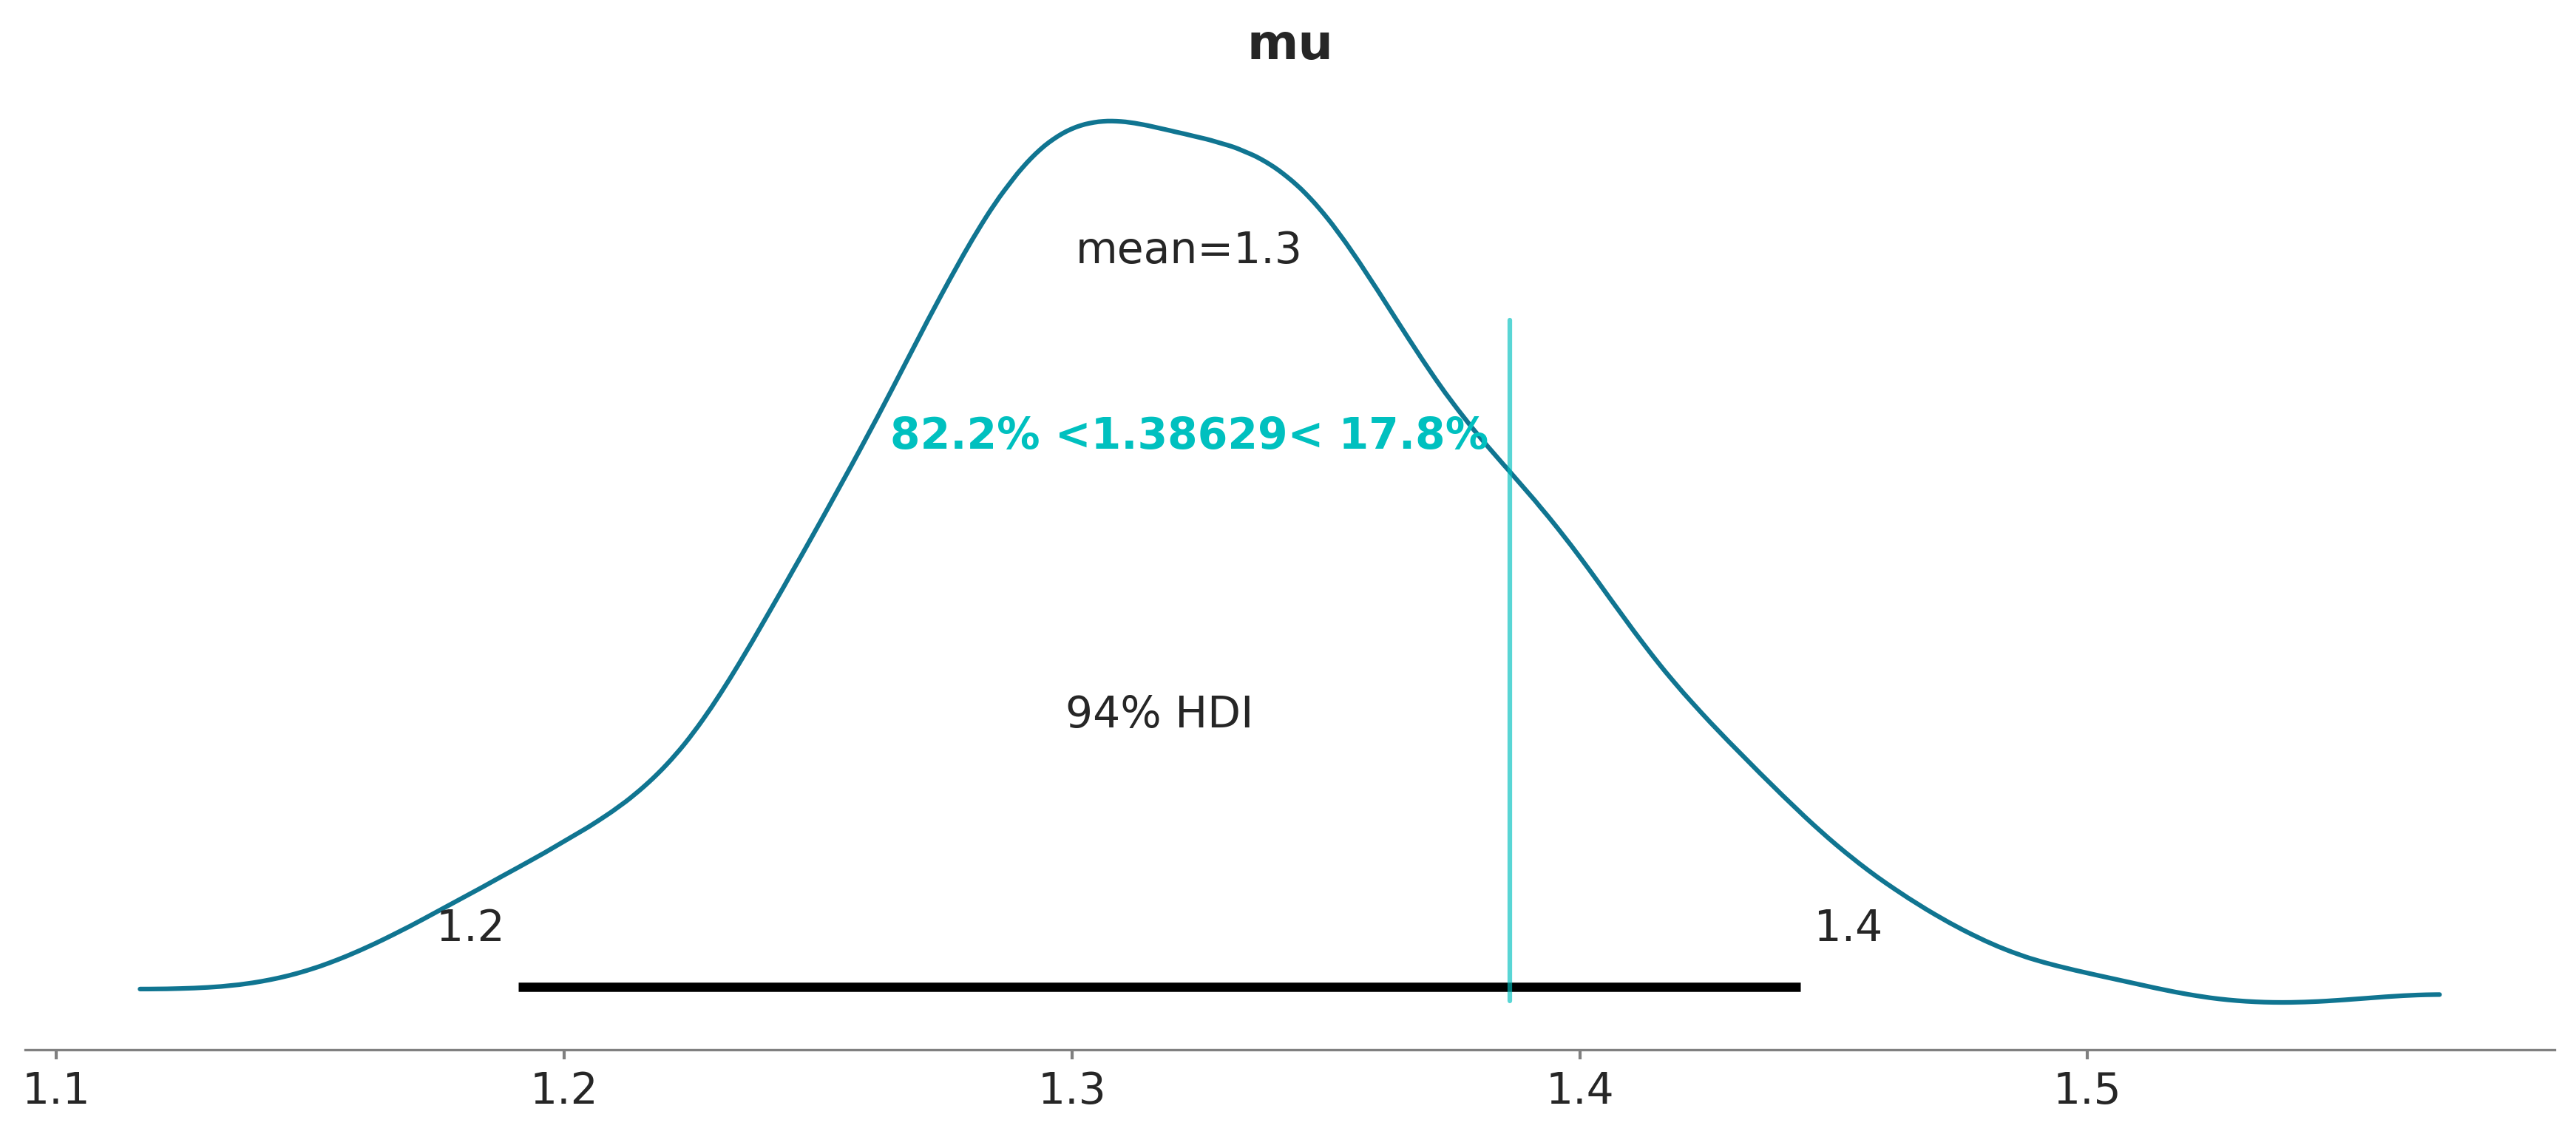

In [26]:
az.plot_posterior(samples, var_names=['mu'], ref_val=np.log(4));

The output

    82% < 1.38629 < 18%
    
informs us that the probability of $\mu$ being less than log(4) is 82% and the corresponding probability of being greater than log(4) is about 18%.

> The posterior probability that the mean level of household radon in Henneprin County is greater than 4 pCi/L is 0.178.

### Prediction

What is the probability that a given household has a log-radon measurement larger than four? To answer this, we make use of the **posterior predictive distribution**.

$$p(z |y) = \int_{\theta} p(z |\theta) p(\theta | y) d\theta$$

where here $z$ is the predicted value and y is the data used to fit the model.

While PyMC has functions for calculating the posterior predictive distribution, we can readily estimate this from the posterior samples of the parameters in the model. First, extract the values of the mean and standard deviation of the sampling distribution:

In [27]:
samples.posterior

<xarray.Dataset> Size: 40kB
Dimensions:  (chain: 2, draw: 1000)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    mu       (chain, draw) float64 16kB 1.353 1.296 1.286 ... 1.345 1.343 1.216
    sigma    (chain, draw) float64 16kB 0.6687 0.7347 0.7628 ... 0.6642 0.6838
Attributes:
    created_at:                 2025-09-05T16:12:40.233103+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1
    sampling_time:              0.48597097396850586
    tuning_steps:               1000

In [28]:
posterior_data = az.extract(samples.posterior)

mus = posterior_data['mu'].values
sigmas = posterior_data['sigma'].values

print("The shape of the mus array is:", mus.shape)
print("The shape of the sigmas array is:", sigmas.shape)

The shape of the mus array is: (2000,)
The shape of the sigmas array is: (2000,)


In [29]:
np.random.seed(RANDOM_SEED)

radon_samples = stats.norm(loc=mus, scale=sigmas).rvs()

In [30]:
(radon_samples > np.log(4)).mean()

np.float64(0.462)

> The posterior probability that a randomly-selected household in Henneprin County contains radon levels in excess of 4 pCi/L is about 0.46.

### Model checking

But, ***how do we know this model is any good?***

Its important to check the fit of the model, to see if its assumptions are reasonable. One way to do this is to perform **posterior predictive checks**. This involves generating simulated data using the model that you built, and comparing that data to the observed data.

One can choose a particular statistic to compare, such as tail probabilities or quartiles, but here it is useful to compare them graphically.

We already have these simulations from the previous exercise!

In [31]:
# Simulated data
x_sim = np.linspace(min(radon_samples) - 1, max(radon_samples) + 1, 1000)
kde_sim = stats.gaussian_kde(radon_samples)
y_sim = kde_sim(x_sim)

# Observed data
x_obs = np.linspace(min(hennepin_radon['log_radon'].to_numpy()) - 1, max(hennepin_radon['log_radon'].to_numpy()) + 1, 1000)
kde_obs = stats.gaussian_kde(hennepin_radon['log_radon'].to_numpy())
y_obs = kde_obs(x_obs)

go.Figure().add_trace(go.Scatter(
    x=x_sim,
    y=y_sim,
    mode='lines',
    name='Simulated',
    line=dict(color='red', width=2)
)).add_trace(go.Scatter(
    x=x_obs,
    y=y_obs,
    mode='lines',
    name='Observed',
    line=dict(color='blue', width=2)
)).add_shape(
    type="line",
    x0=np.log(4),
    y0=0,
    x1=np.log(4),
    y1=max(max(y_sim), max(y_obs)),
    line=dict(color="black", dash="dash"),
).add_annotation(
    x=np.log(4),
    y=max(max(y_sim), max(y_obs))/2,
    text="log(4)",
    showarrow=True,
    arrowhead=1,
    ax=30,
    ay=0
).update_layout(
    title='KDE: Observed vs Simulated Log Radon Levels',
    xaxis_title='Log Radon Level',
    yaxis_title='Density',
    width=600,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    )
)

## Bayesian Estimation for Two Groups

Let's move on to a slightly different problem: rather than estimating a single group's distribution, what if we have data from two unknown distributions and we want to estimate how different they are.

We will use a fictitious example from Kruschke (2012) concerning the evaluation of a clinical trial for drug evaluation. The trial aims to evaluate the efficacy of a "smart drug" that is supposed to increase intelligence by comparing IQ scores of individuals in a treatment arm (those receiving the drug) to those in a control arm (those recieving a placebo). There are 47 individuals and 42 individuals in the treatment and control arms, respectively.

In [32]:
drug = pl.DataFrame(dict(iq=(101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101),
                         group='drug'))
placebo = pl.DataFrame(dict(iq=(99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99),
                            group='placebo'))
n1 = len(drug)
n0 = len(placebo)

trial_data = pl.concat([drug, placebo])

# Create histogram using plotly express directly with polars DataFrame
fig = px.histogram(
    trial_data, 
    x="iq", 
    color="group",
    barmode="overlay",
    histnorm="percent",
    labels={"iq": "IQ Score", "group": "Group"},
    title="Distribution of IQ Scores by Group",
    color_discrete_map={"drug": "#636EFA", "placebo": "#EF553B"}
)

# Update layout for better appearance
fig.update_layout(
    legend_title_text="",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    xaxis_title="IQ Score",
    yaxis_title="Percentage"
)
fig.show()

iq = trial_data.select("iq").to_numpy().squeeze()
group = trial_data["group"].cast(pl.Categorical).to_physical().to_numpy().squeeze()

Since there appear to be extreme ("outlier") values in the data, we will choose a Student-t distribution to describe the distributions of the scores in each group (see the distribution gallery above). This sampling distribution adds **robustness** to the analysis, as a T distribution is less sensitive to outlier observations, relative to a normal distribution. 

The three-parameter Student-t distribution allows for the specification of a mean $\mu$, a precision (inverse-variance) $\lambda$ and a degrees-of-freedom parameter $\nu$:

$$f(x|\mu,\lambda,\nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})} \left(\frac{\lambda}{\pi\nu}\right)^{\frac{1}{2}} \left[1+\frac{\lambda(x-\mu)^2}{\nu}\right]^{-\frac{\nu+1}{2}}$$
           
the degrees-of-freedom parameter essentially specifies the "normality" of the data, since larger values of $\nu$ make the distribution converge to a normal distribution, while small values (close to zero) result in heavier tails.

In [33]:
x = np.linspace(-4, 4, 1000)

normal_dist = stats.norm.pdf(x, 0, 1)
t_dist = stats.t.pdf(x, df=3)

go.Figure().add_trace(go.Scatter(
    x=x,
    y=normal_dist,
    mode='lines',
    name='Normal(0,1)',
    line=dict(color='blue', width=2)
)).add_trace(go.Scatter(
    x=x,
    y=t_dist,
    mode='lines',
    name='Student-t(df=3)',
    line=dict(color='red', width=2)
)).update_layout(
    title='Normal vs Student-t Distribution',
    xaxis_title='x',
    yaxis_title='Density',
    width=600,
    legend=dict(
        orientation="h",
        yanchor="bottom", 
        y=1.02, 
        xanchor="right", 
        x=1
    )
)


Thus, the likelihood functions of our model are specified as follows:

$$\begin{align}
y^{(drug)}_i &\sim T(\nu, \mu_1, \sigma_1) \\
y^{(placebo)}_i &\sim T(\nu, \mu_2, \sigma_2)
\end{align}$$

As a simplifying assumption, we will assume that the degree of normality $\nu$ is the same for both groups. 

### Prior choice

Since the means are real-valued, we will apply normal priors. Since we know something about the population distribution of IQ values, we will center the priors at 100, and use a standard deviation that is more than wide enough to account for plausible deviations from this population mean:

$$\mu_k \sim N(100, 10^2)$$

In [34]:
with pm.Model() as drug_model:
    
    mu = pm.Normal('mu', 100, sigma=10, shape=2)

In [35]:
print("Here is a random sample from the mu prior:", pm.draw(mu))

Here is a random sample from the mu prior: [97.03189028 79.2100906 ]


Similarly, we will use a uniform prior for the standard deviations, with an upper bound of 20.

In [36]:
with drug_model:
    
    sigma = pm.Uniform('sigma', lower=0, upper=20, shape=2)

For the overdispersion parameter $\nu$, we will use an **exponential** distribution with a mean of 30; this allocates high prior probability over the regions of the parameter that describe the range from normal to heavy-tailed data under the Student-T distribution.

In [37]:
with drug_model:
    nu = pm.Exponential('nu', 1/30) 

In [38]:
samples = pm.draw(nu, 10_000)

fig = px.histogram(
    x=samples, 
    nbins=50, 
    title="Exponential Distribution (1/30)",
    labels={"x": "Value", "count": "Frequency"},
    opacity=0.7
).update_layout(
    xaxis_title="Value",
    yaxis_title="Frequency",
    width=600,
    showlegend=False
).update_xaxes(range=[0, 100])

fig.show()

In [39]:
with drug_model:

    like = pm.StudentT('placebo_like', nu=nu, mu=mu[group], sigma=sigma[group], observed=iq)

Now that the model is fully specified, we can turn our attention to tracking the posterior quantities of interest. Namely, we can calculate the difference in means between the drug and placebo groups.

In [40]:
with drug_model:
    
    diff_of_means = pm.Deterministic('difference of means', mu[0] - mu[1])

In [41]:
with drug_model:
    
    drug_trace = pm.sample(random_seed=RNG)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


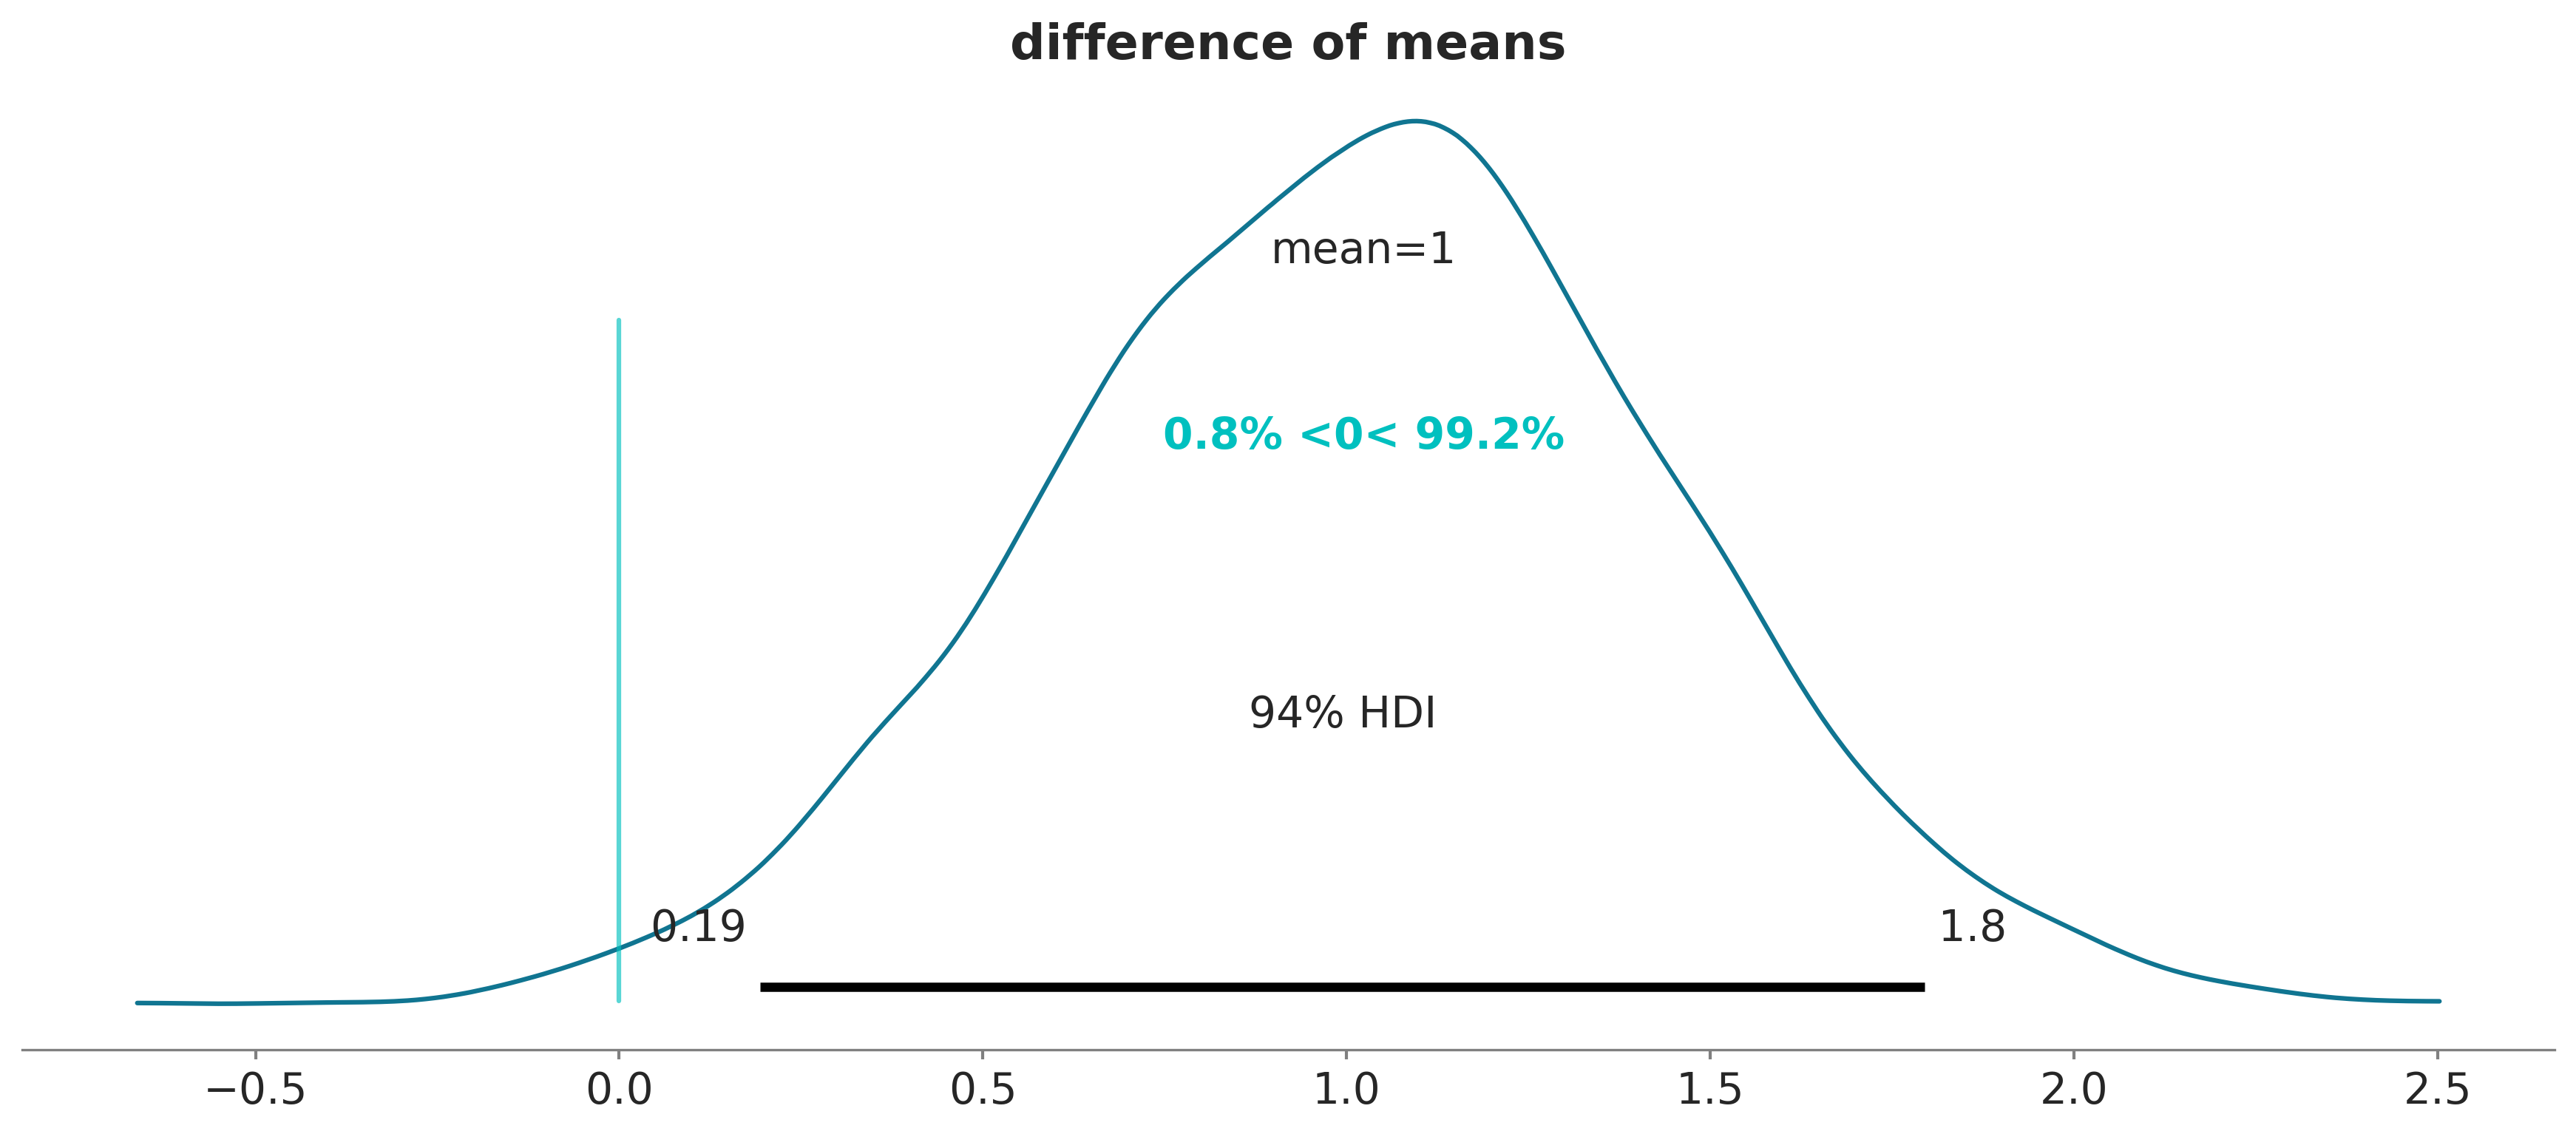

In [42]:
az.plot_posterior(drug_trace, 
          var_names=['difference of means'],
          ref_val=0);

> The posterior probability that the mean IQ of subjects in the treatment group is greater than that of the control group is approximately 0.99.

---

# References

Gelman, Andrew, John B. Carlin, Hal S. Stern, David B. Dunson, Aki Vehtari, and Donald B. Rubin. 2013. [Bayesian Data Analysis, Third Edition](http://www.stat.columbia.edu/~gelman/book/). CRC Press.

Downey, Allen. 2021. [Think Bayes: Bayesian Statistics in Python, Second Edition](https://allendowney.github.io/ThinkBayes2/). O'Reilly Media.

Pilon, Cam-Davidson. [Probabilistic Programming and Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)

In [43]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Sep 05 2025

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.5.0

arviz : 0.22.0
scipy : 1.16.1
pymc  : 5.25.1
plotly: 6.3.0
polars: 1.32.3
numpy : 2.2.6

Watermark: 2.5.0

